In [1]:
import tarfile
import os
import pathlib
import numpy as np
from time import time
# temp
import sys
sys.path.append('/workspace/shared_workspace/deep-learning-models/models/vision/detection')

import tensorflow_addons as tfa
import tensorflow as tf
import horovod.tensorflow as hvd

from awsdet.models.detectors.mask_rcnn import MaskRCNN
from awsdet.datasets import DATASETS, build_dataloader
from awsdet.datasets import build_dataset, build_dataloader
from awsdet.models import build_detector
from awsdet.utils.schedulers import schedulers
from awsdet.core import CocoDistEvalmAPHook, CocoDistEvalRecallHook
from awsdet.utils.runner.hooks.logger import tensorboard, text
from awsdet.utils.runner.hooks import checkpoint, iter_timer, visualizer
from awsdet.apis.train import parse_losses, batch_processor, build_optimizer, get_root_logger
from awsdet.utils.misc import Config
import horovod.tensorflow as hvd
from awsdet.utils.runner import sagemaker_runner
from awsdet.utils.schedulers.schedulers import WarmupScheduler
import argparse

from awsdet.utils import visualize
from pycocotools.cocoeval import COCOeval

from awsdet.core.bbox import transforms
import matplotlib.pyplot as plt

from awsdet.utils.fileio import load, dump
import os.path as osp
from awsdet.core.evaluation.coco_utils import fast_eval_recall, results2json
##########################################################################################
# Setup horovod and tensorflow environment
##########################################################################################

fp16 = True
hvd.init()
tf.config.experimental_run_functions_eagerly(True)
tf.config.optimizer.set_experimental_options({"auto_mixed_precision": fp16})
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
if gpus:
    tf.config.experimental.set_visible_devices(gpus[hvd.local_rank()], 'GPU')


/usr/local/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
cfg = Config.fromfile("/workspace/shared_workspace/deep-learning-models/models/vision/detection/configs/docker_mask_rcnn.py")

In [3]:
cfg.batch_size_per_device = 1
cfg.workers_per_gpu = 1
cfg.global_batch_size = cfg.batch_size_per_device * hvd.size()
datasets = build_dataset(cfg.data.train)
tf_datasets = [build_dataloader(datasets,
                     cfg.batch_size_per_device,
                     cfg.workers_per_gpu,
                     num_gpus=hvd.size(),
                     dist=True)]

loading annotations into memory...
Done (t=15.01s)
creating index...
index created!


In [4]:
val_dataset = build_dataset(cfg.data.val)
val_tdf, val_size = build_dataloader(val_dataset,
                                     cfg.batch_size_per_device,
                                     cfg.workers_per_gpu,
                                     num_gpus=hvd.size(),
                                     dist=True,
                                     shuffle=False)

loading annotations into memory...
Done (t=0.47s)
creating index...
index created!


In [5]:
model = build_detector(cfg.model,
                           train_cfg=cfg.train_cfg,
                           test_cfg=cfg.test_cfg)

In [6]:
_ = model(next(iter(tf_datasets[0][0])), training=True)

Starting new loop for GPU: 0


In [7]:
model.load_weights('/workspace/shared_workspace/output/011/mask_rcnn')

In [8]:
val_iter = iter(val_tdf)

In [9]:
img, img_meta = next(val_iter)

Starting new loop for GPU: 0


In [10]:
detections = model((img, img_meta), training=False)

In [11]:
def get_original_image(img, img_meta, cfg):
    img = img[:int(img_meta[3]), :int(img_meta[4]), :]
    img = tf.image.resize(img, tf.cast(img_meta[:2], tf.int32))
    img = tf.reverse(img, axis=[-1])
    img = (img + cfg.data.val.mean)
    if img_meta[-1]:
        img = tf.reverse(img, axis=[1])
    return img
    



In [12]:
original_image = get_original_image(img[0], img_meta[0], cfg)
bboxes = transforms.bbox_mapping_back(detections['bboxes'], img_meta[0])
image = visualize.make_image(original_image.numpy(), bboxes[:5].numpy(),
                     detections['labels'][:5].numpy(), visualize.coco_categories,
                     scores=detections['scores'][:5].numpy())

In [13]:
image = visualize.make_image(original_image.numpy(), bboxes[:5].numpy(),
                     detections['labels'][:5].numpy(), visualize.coco_categories,
                     scores=detections['scores'][:5].numpy())

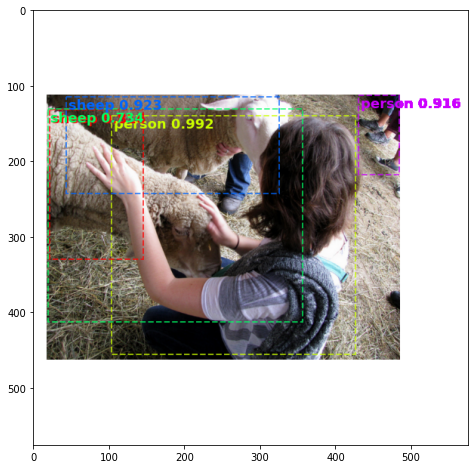

In [14]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image)

In [15]:
labels = detections['labels']
scores = detections['scores']

In [16]:
result = transforms.bbox2result(bboxes, labels, scores, num_classes=val_dataset.CLASSES+1)

In [17]:
from tqdm.notebook import tqdm

In [18]:
detections = model(next(val_iter), training=False)

In [19]:
def model_eval(data_batch):
    img, img_metas = data_batch
    training=False
    C2, C3, C4, C5 = model.backbone(img, training=training)
    P2, P3, P4, P5, P6 = model.neck((C2, C3, C4, C5), training=training)
    rpn_feature_maps = [P2, P3, P4, P5, P6]
    rcnn_feature_maps = [P2, P3, P4, P5]
    rpn_class_logits, rpn_probs, rpn_deltas = model.rpn_head(rpn_feature_maps, training=training)
    proposals_list = model.rpn_head.get_proposals(
                rpn_probs, rpn_deltas, img_metas, training=training)

    rois_list = proposals_list
    bbox_pooled_regions_list = model.bbox_roi_extractor(
                (rois_list, rcnn_feature_maps, img_metas), training=training)
    rcnn_class_logits, rcnn_probs, rcnn_deltas = \
        model.bbox_head(bbox_pooled_regions_list, training=training)
    detections_dict = {}
    detections_list = model.bbox_head.get_bboxes(rcnn_probs, 
                                                            rcnn_deltas, 
                                                            rois_list, 
                                                            img_metas)
    detections_dict = {
                        'bboxes': detections_list[0][0],
                        'labels': detections_list[0][1],
                        'scores': detections_list[0][2]}
    mask_pooled_regions_list = model.mask_roi_extractor(
        ([detections_dict['bboxes']], rcnn_feature_maps, img_metas), training=training)
    rcnn_masks = model.mask_head(mask_pooled_regions_list[0])
    mask_inds = tf.transpose(tf.stack([tf.range(tf.shape(detections_dict['labels'])), 
                                       detections_dict['labels']]))
    rcnn_masks = tf.expand_dims(tf.gather_nd(tf.transpose(rcnn_masks, [0, 3, 1, 2]), mask_inds), axis=-1)
    detections_dict['masks'] = rcnn_masks
    return detections_dict

In [20]:
img, metas = next(val_iter)
detections = model_eval((img, metas))

In [21]:
bboxes = tf.round(transforms.bbox_mapping_back(detections['bboxes'], metas[0]))
labels = detections['labels']
scores = detections['scores']
height, width = (bboxes[:,2]-bboxes[:,0] + 1, bboxes[:,3]-bboxes[:,1] + 1)

In [40]:
def mask_to_result(bboxes, masks, labels, meta, threshold=0.25, num_classes=81):
    '''
    Reformat masks from model output to be used for eval
    '''
    height, width = (bboxes[:,2]-bboxes[:,0], bboxes[:,3]-bboxes[:,1])
    sizes = tf.cast(tf.transpose(tf.stack([height, width])), tf.int32)
    img_size = meta[:2]
    if meta[-1]:
        masks = tf.reverse(masks, axis=[2])
    mask_list = []
    bboxes = tf.split(bboxes, 100)
    for idx in range(tf.shape(masks)[0]):
        mask = masks[idx]
        size = sizes[idx]
        bbox = bboxes[idx][0]
        bbox = tf.reshape(tf.transpose(tf.stack([tf.clip_by_value(bbox[0::2], 0, img_size[0]), 
                                         tf.clip_by_value(bbox[1::2], 0, img_size[1])])), [-1])
        if tf.math.multiply(*size)==0:
            mask_list.append(tf.cast(-tf.ones(tf.cast(img_size, tf.int32)), dtype=tf.int32))
        else:
            a_mask = tf.image.resize(mask, size)
            a_mask = tf.squeeze(a_mask>threshold)
            a_mask = tf.cast(a_mask, tf.int32)
            if a_mask.ndim!=2:
                a_mask = tf.expand_dims(a_mask, axis=0)
            a_mask = tf.pad(a_mask, [[tf.cast(bbox[0], tf.int32), 
                                      tf.cast(img_size[0]-bbox[2], tf.int32)],
                                     [tf.cast(bbox[1], tf.int32), 
                                      tf.cast(img_size[1]-bbox[3], tf.int32)]])
        mask_list.append(a_mask)
    
    '''masks = [tf.cast(tf.squeeze(tf.image.resize(mask, size)>threshold), tf.int32) \
             if tf.math.multiply(*size) else tf.cast(-tf.ones(size, dtype=tf.int64), tf.uint8) \
             for mask, size in zip(masks, sizes)]
    masks = [tf.pad(mask, [[int(bbox[0]), int(img_size[0]-bbox[2])],
                            int(bbox[1]), int(img_size[1]-bbox[3])]) \
             for mask, bbox in zip(masks, bboxes)]'''
    #mask_dict = defaultdict(list)
    mask_list_of_lists = [[]]*num_classes
    for mask, label in zip(mask_list, labels):
        mask_list_of_lists[label.numpy()].append(mask.numpy())
    return mask_list_of_lists

In [41]:
mask_dict = mask_to_result(bboxes, detections['masks'], labels, metas[0])

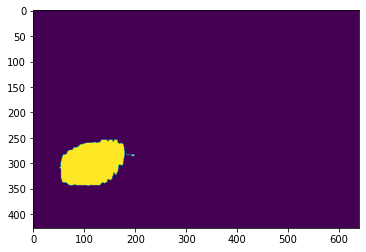

In [42]:
plt.imshow(mask_dict[labels[0].numpy()][0])

In [43]:
labels[0].numpy()

58

In [44]:
original_image = get_original_image(img[0], metas[0], cfg)
'''image = visualize.make_image(original_image.numpy(), bboxes[:5].numpy(),
                     detections['labels'][:5].numpy(), visualize.coco_categories,
                     scores=detections['scores'][:5].numpy())
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image)'''

"image = visualize.make_image(original_image.numpy(), bboxes[:5].numpy(),\n                     detections['labels'][:5].numpy(), visualize.coco_categories,\n                     scores=detections['scores'][:5].numpy())\nfig, ax = plt.subplots(figsize=(8, 8))\nax.imshow(image)"

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


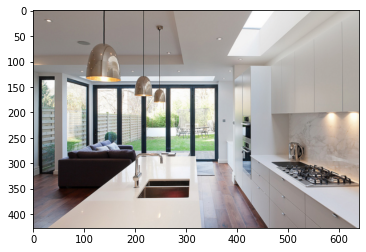

In [45]:
plt.imshow(original_image/255.)

In [604]:
def evaluate(batch):
    detections = model_eval(batch)
    bboxes = tf.round(transforms.bbox_mapping_back(detections['bboxes'], batch[1][0]))
    labels = detections['labels']
    scores = detections['scores']
    result = transforms.bbox2result(bboxes, labels, 
                                          scores, num_classes=val_dataset.CLASSES+1)
    masks = mask_to_result(bboxes, detections['masks'], labels, batch[1][0])
    return result, masks

In [605]:
bbox_results = []
mask_results = []
for batch in tqdm(val_tdf.take(100), total=100):
    detections = model_eval(batch)
    bboxes = tf.round(transforms.bbox_mapping_back(detections['bboxes'], batch[1][0]))
    labels = detections['labels']
    scores = detections['scores']
    result = transforms.bbox2result(bboxes, labels, 
                                          scores, num_classes=val_dataset.CLASSES+1)
    masks = mask_to_result(bboxes, detections['masks'], labels, batch[1][0])
    bbox_results.append(result)
    mask_results.append(masks)

Starting new loop for GPU: 0



In [606]:
'''sizes = tf.cast(tf.transpose(tf.stack([height, width])), tf.int32)
img_size = meta[:2]
if meta[-1]:
    masks = tf.reverse(masks, axis=[2])
mask_list = []
bboxes_split = tf.split(bboxes, 100)
for idx in range(tf.shape(detections['masks'])[0]):
    mask = detections['masks'][0]
    size = sizes[0]
    bbox = bboxes_split[0][0]
    bbox = tf.reshape(tf.transpose(tf.stack([tf.clip_by_value(bbox[0::2], 0, img_size[0]), 
                                         tf.clip_by_value(bbox[1::2], 0, img_size[1])])), [-1])
    a_mask = tf.image.resize(mask, size)
    a_mask = tf.squeeze(a_mask>0.25)
    a_mask = tf.cast(a_mask, tf.int32)
    print(a_mask.ndim)
    a_mask = tf.pad(a_mask, [[tf.cast(bbox[0], tf.int32), 
                                      tf.cast(img_size[0]-bbox[2], tf.int32)],
                                     [tf.cast(bbox[1], tf.int32), 
                                      tf.cast(img_size[1]-bbox[3], tf.int32)]])'''

"sizes = tf.cast(tf.transpose(tf.stack([height, width])), tf.int32)\nimg_size = meta[:2]\nif meta[-1]:\n    masks = tf.reverse(masks, axis=[2])\nmask_list = []\nbboxes_split = tf.split(bboxes, 100)\nfor idx in range(tf.shape(detections['masks'])[0]):\n    mask = detections['masks'][0]\n    size = sizes[0]\n    bbox = bboxes_split[0][0]\n    bbox = tf.reshape(tf.transpose(tf.stack([tf.clip_by_value(bbox[0::2], 0, img_size[0]), \n                                         tf.clip_by_value(bbox[1::2], 0, img_size[1])])), [-1])\n    a_mask = tf.image.resize(mask, size)\n    a_mask = tf.squeeze(a_mask>0.25)\n    a_mask = tf.cast(a_mask, tf.int32)\n    print(a_mask.ndim)\n    a_mask = tf.pad(a_mask, [[tf.cast(bbox[0], tf.int32), \n                                      tf.cast(img_size[0]-bbox[2], tf.int32)],\n                                     [tf.cast(bbox[1], tf.int32), \n                                      tf.cast(img_size[1]-bbox[3], tf.int32)]])"

In [607]:
#mask_results[0][1][0][:, :, np.newaxis]

In [608]:
import pycocotools.mask as mask_util

def yxyx2xywh(bbox):
    _bbox = bbox.tolist()
    ret = [
        _bbox[1],
        _bbox[0],
        _bbox[3] - _bbox[1] + 1,
        _bbox[2] - _bbox[0] + 1,
    ]
    return ret

bbox_json_results = []
segm_json_results = []

for idx in range(len(bbox_results)):
    img_id = val_dataset.img_ids[idx]
    det = bbox_results[idx]
    seg = mask_results[idx]
    for label in range(len(det)):
        bboxes = det[label]
        for i in range(bboxes.shape[0]):
            data = dict()
            data['image_id'] = img_id
            data['bbox'] = yxyx2xywh(bboxes[i])
            data['score'] = float(bboxes[i][4])
            data['category_id'] = val_dataset.cat_ids[label-1]
            bbox_json_results.append(data)
        segms = seg[label]
        mask_score = [bbox[4] for bbox in bboxes]
        for i in range(bboxes.shape[0]):
            data = dict()
            data['image_id'] = img_id
            data['bbox'] = yxyx2xywh(bboxes[i])
            data['score'] = float(bboxes[i][4])
            data['category_id'] = val_dataset.cat_ids[label-1]
            data['segmentation'] = mask_util.encode(
                    np.array(
                        segms[i][:, :, np.newaxis], order='F',
                        dtype='uint8'))[0]
            data['segmentation']['counts'] = data['segmentation']['counts'].decode()
            segm_json_results.append(data)

In [609]:
imgIds = list(np.unique([a_result['image_id'] for a_result in bbox_json_results]))

In [610]:
results = (bbox_json_results, segm_json_results)

In [611]:
#segm_json_results[0]

In [612]:
#result_files = results2json(val_dataset, results, 'temp_eval')
dump(results[0], 'temp_bbox.json')
dump(results[1], 'temp_seg.json')

In [616]:
res_type = 'segm'
cocoGt = val_dataset.coco
#imgIds = cocoGt.getImgIds()
cocoDt = cocoGt.loadRes('temp_seg.json')
cocoEval = COCOeval(cocoGt, cocoDt, res_type)

Loading and preparing results...
DONE (t=0.05s)
creating index...
index created!


In [617]:
cocoEval.params.imgIds = imgIds

In [618]:
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.97s).
Accumulating evaluation results...
DONE (t=0.34s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.132
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.325
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.078
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.081
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.151
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.168
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.128
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.191
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.193
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.121
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100

In [46]:
mask_results[0][1][0][:,:,np.newaxis].shape

NameError: name 'mask_results' is not defined

In [476]:
tf.random.normal([1])[0]>1

<tf.Tensor: shape=(), dtype=bool, numpy=False>

In [626]:
tf.image.central_crop(img[0], tf.random.uniform(shape=[], minval=0.7, maxval=1.0))

<tf.Tensor: shape=(), dtype=float32, numpy=0.8701315>

InvalidArgumentError: Index out of range using input dim 0; input has only 0 dims [Op:StridedSlice] name: strided_slice/